# BOSTON AIRBNB ANALYTICS


 ----- IMPORT LIBRARIES AND LOAD THE INPUT FILES ------

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr


calendar = pd.read_csv('./calendar.csv')
listings = pd.read_csv('./listings.csv')


----- DATA EXPLORATION -----
-----------------------------------



In [2]:

# display calendar dataset information

print(calendar.info(), '\n')

# display min/max date

print('Min date is',calendar['date'].min())
print('Max date is',calendar['date'].max(),'\n')

# check % of missing values in each column

print (calendar.isnull().sum()/calendar.shape[0]*100, '\n')

# check occupancy rate 
print('Occupancy Rate:',len(calendar[calendar['available']=='f'])/calendar.shape[0]*100, '\n')

# list the first 10 rows

calendar.head(10)

# OBSERVATION:
#   1)  calendar dataset has 4 columns and 1,308,890 rows 
#   2)  contains 1 year data from 06-09-2016 to 05-09-2017
#   3)  1 numeric variable and 3 categorical variables
#   4)  'price' is not numeric datatype as it contains $ sign
#   5)  'price' contains 50.87% NaN values
#   6)  there is no 'price' where available = 'f' (properties were booked)
#   7)  the price is listed where properties were available
#   8)  occupancy rate is 50.87%


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
None 

Min date is 2016-09-06
Max date is 2017-09-05 

listing_id     0.000000
date           0.000000
available      0.000000
price         50.871578
dtype: float64 

Occupancy Rate: 50.87157820748879 



" Observation:\n   1)  calendar dataset has 4 columns and 1,308,890 rows \n   2)  contains 1 year data from 06-09-2016 to 05-09-2017\n   3)  1 numeric variable and 3 categorical variables\n   4)  'price' is not numeric datatype as it contains $ sign\n   5)  'price' contains 50.87% NaN values\n   6)  there is no 'price' where available = 'f' (properties were booked)\n   7)  the price is listed where properties were available\n   8)  occupancy rate is 50.87%\n  "

In [3]:

# display 'listings' dataset information

print(listings.info(), '\n')

# list the columns with more than 50% missing values

print(set(listings.columns[listings.isnull().mean() > 0.50]),'\n')

# list the first 5 rows

print(listings.head(5))

# Observation:
#   1)  listings dataset has 95 columns and 3,584 rows 
#   2)  33 numeric variables and 62 categorical variables
#   3)  'price' is not numeric datatype as it contains $ sign


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

" Observation:\n   1)  listings dataset has 95 columns and 3,584 rows \n   2)  33 numeric variables and 62 categorical variables\n   3)  'price' is not numeric datatype as it contains $ sign\n\n"


----- DATA PREPARATION AND VISUALISATION -----
-----------------------------------


In [4]:
# convert 'price' to float datatype

calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

In [5]:
# merge calendar and listings datasets

boston_df =  pd.merge(calendar, listings, left_on='listing_id', right_on='id')

In [6]:
# as both calendar and listings datasets have column 'price', when merged the column from calendar is automatically named 'price_x', 
# the below step will rename 'price_x' to 'price'

boston_df= boston_df.rename(columns = {'price_x': 'price'})



In [7]:
# extract  'week_day' and 'month' from 'date'

boston_df['week_day'] = pd.DatetimeIndex(boston_df['date']).dayofweek
boston_df['month']= pd.DatetimeIndex(boston_df['date']).month

In [8]:
# Split boston_df to 2 datasets 'Available' and 'Unavailable' 

df_avail = boston_df[boston_df['available'] == 't']
df_unavail = boston_df[boston_df['available'] == 'f']

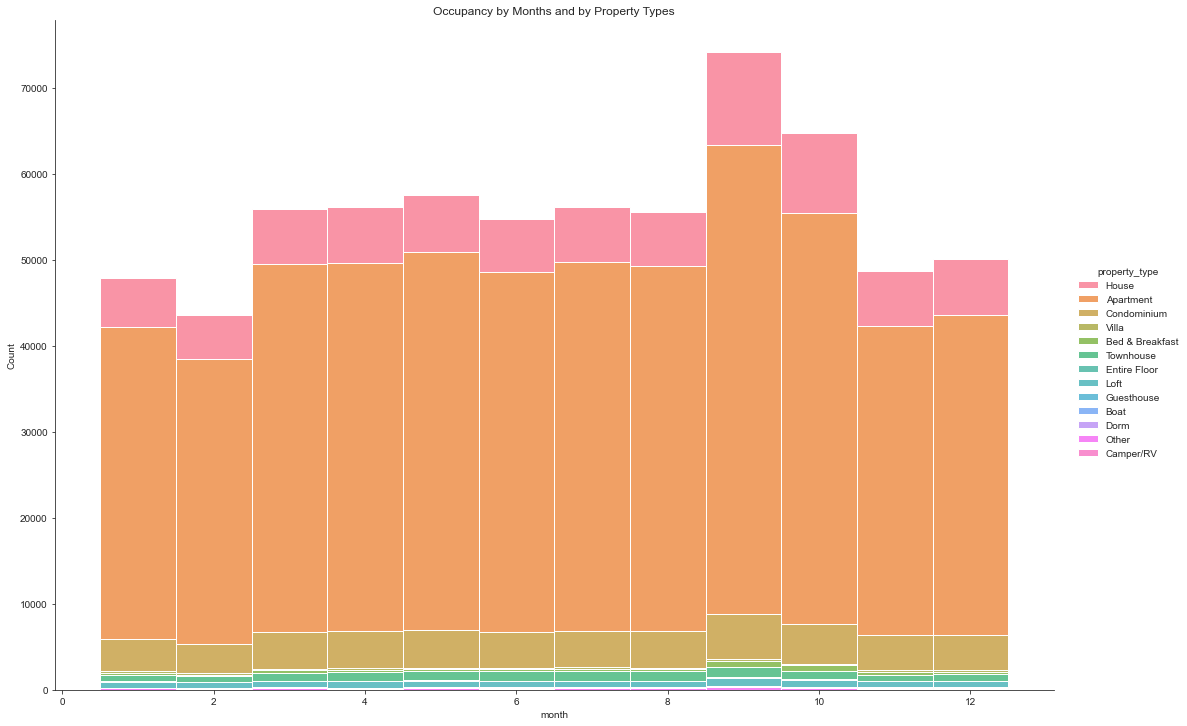

In [9]:
# create chart showing occupancy by Months and by Property Types

sns.set_style("ticks")
ax = sns.displot(df_unavail, x="month", hue="property_type", multiple="stack", stat="count",height=10, discrete=True , aspect=1.5 )
ax.set(title="Occupancy by Months and by Property Types")

###### Chart observation : 
September has the highest bookings, following is October. Feb has the lowest bookings. Apartment is the most  demanded renting property, following by house and then condominium. Exact number/percentage of bookings by months and by properties can be obtained in following codes:

In [10]:
# count of bookings by months and by property_type 
    
df_unavail.groupby(['month', 'property_type']).count()['date']

# percentage of bookings (occupancy rate) by months and by property_type 

booking_df = df_unavail.groupby(['month', 'property_type']).count()['date']/boston_df.groupby(['month', 'property_type']).count()['date']*100


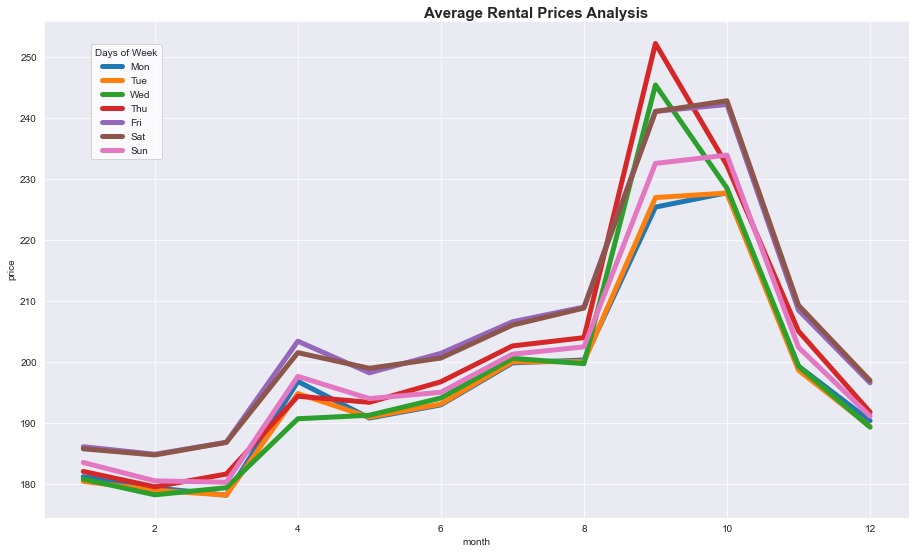

In [11]:
# Create a chart showing the average price by month and week days

f = plt.figure(figsize=(25, 15))
gs = f.add_gridspec(2, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    ax = sns.lineplot(x="month", y="price", hue = "week_day",palette="tab10", linewidth=5,legend = False,
       data=df_avail, ci=None  )

f.suptitle("Average Rental Prices Analysis",fontsize = 15,weight='bold', x = 0.3, y = 0.98, ha='center')
f.legend(bbox_to_anchor=(0.05, 0.95),title='Days of Week', loc='upper left', labels=['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun'])
f.tight_layout()


###### Chart observation : 
Rental price is lowest in February and March, it gradually increases and reaches the peak in September and October. Except September where price is highest on Thurday, Friday and Saturday are more expensive than the rest of the week.

----- RENTAL PRICE PREDICTION -----
-----------------------------------

###### DATA PREPARATION
Dataset 'df_avail' will be used in building model as it contains the rental price influenced by seasonal factors (ie. month of the year, day of the week)

In [12]:
# display columns which have correlation with price > 0.4. 

cor = df_avail.corr()
cor_df = abs(cor["price"])
cor_df[cor_df>0.4]

price           1.000000
accommodates    0.483006
bedrooms        0.432066
square_feet     0.565067
price_y         0.879527
Name: price, dtype: float64

In [13]:
# to avoid Multicolinearity issue, we need to check the correlation between 3 numeric independent variables

cor_df = abs(cor[["accommodates","bedrooms","square_feet"]])
cor_df[cor_df>0.4]

# the result show there are strong correlation between those 3, therefore we should include only 1 of them in the model
# the column 'accommodates' is selected as it has no missing values

,accommodates,bedrooms,square_feet
listing_id,NaN,NaN,NaN
price,0.483006,0.432066,0.565067
id,NaN,NaN,NaN
scrape_id,NaN,NaN,NaN
host_id,NaN,NaN,NaN
host_listings_count,NaN,NaN,NaN
host_total_listings_count,NaN,NaN,NaN
neighbourhood_group_cleansed,NaN,NaN,NaN
latitude,NaN,NaN,NaN
longitude,NaN,NaN,NaN


In [14]:
# keep the columns being used in building model

df_model = df_avail[['price','month','week_day','latitude','longitude','property_type','accommodates','cancellation_policy']]

In [15]:
# display dataset information
df_model.info()

# The result shows there are 6 numeric columns and 3 categorical columns. 
# The column 'property_type' contains null values (not null count < total records)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643037 entries, 365 to 1308879
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                643037 non-null  float64
 1   month                643037 non-null  int64  
 2   week_day             643037 non-null  int64  
 3   latitude             643037 non-null  float64
 4   longitude            643037 non-null  float64
 5   property_type        642889 non-null  object 
 6   accommodates         643037 non-null  int64  
 7   cancellation_policy  643037 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 44.2+ MB


In [16]:
# remove records with NaN values
df_model = df_model.dropna()

In [17]:
# create a list of categorical variables
cat_list = ['cancellation_policy','property_type']

# create a list of explanatory numeric variables
num_list = ['latitude','longitude','week_day','month','accommodates']

In [18]:
# create dummy columns for categorical variables

df_dummy = df_model[cat_list]
df_dummy =pd.get_dummies(df_dummy, prefix=cat_list)



In [19]:
# rescale explanatory numeric variables

for feature in num_list:
    shift = df_model[feature].mean()
    scale = df_model[feature].std()
    if scale == 0.:
        del df_model[feature]
        print ('Feature %s was dropped because it has no variance' % feature)
    else:
        print ('Rescaled %s' % feature)
        df_model[feature] =  (df_model[feature] - shift).astype(np.float64) / scale




Rescaled latitude
Rescaled longitude
Rescaled week_day
Rescaled month
Rescaled accommodates


In [20]:
df_model.head()

,price,month,week_day,latitude,longitude,property_type,accommodates,cancellation_policy
365,65.0,0.454493,-0.993463,-1.976301,-1.616504,Apartment,-0.59027,moderate
366,65.0,0.454493,-1.492512,-1.976301,-1.616504,Apartment,-0.59027,moderate
367,65.0,0.454493,1.501782,-1.976301,-1.616504,Apartment,-0.59027,moderate
368,75.0,0.454493,1.002733,-1.976301,-1.616504,Apartment,-0.59027,moderate
369,75.0,0.454493,0.503684,-1.976301,-1.616504,Apartment,-0.59027,moderate


In [21]:
# remove categorical variables 

df_model = df_model.drop(['property_type','cancellation_policy'],axis=1)

# add dummy categorical variables

df_knn = pd.concat([df_dummy, df_model], axis=1)


In [22]:
df_knn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642889 entries, 365 to 1308879
Data columns (total 23 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   cancellation_policy_flexible         642889 non-null  uint8  
 1   cancellation_policy_moderate         642889 non-null  uint8  
 2   cancellation_policy_strict           642889 non-null  uint8  
 3   cancellation_policy_super_strict_30  642889 non-null  uint8  
 4   property_type_Apartment              642889 non-null  uint8  
 5   property_type_Bed & Breakfast        642889 non-null  uint8  
 6   property_type_Boat                   642889 non-null  uint8  
 7   property_type_Camper/RV              642889 non-null  uint8  
 8   property_type_Condominium            642889 non-null  uint8  
 9   property_type_Dorm                   642889 non-null  uint8  
 10  property_type_Entire Floor           642889 non-null  uint8  
 11  property_t

In [23]:
# split dataset for cross validation, 20% for testing and 80% for training

Y = df_knn['price']
X = df_knn.drop('price', axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

###### MODEL TRAINING USING K-NEAREST NEIGBOURS REGRESSSION
 

The below elbow method can be used to determine the optimum number of neighbours, however given the huge volumn, 
it takes forever to complete, so I skipped this step and experimented with n-neigbour = 3, 5, 7

from sklearn.cluster import KMeans
score = []
range_value = range(1,20)
for i in range_value:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_train)
    score.append(kmeans.inertia_) 

In [25]:
# train the model, after experiment with different values, n_neibhours = 3 give the most accurate prediction

clf = KNeighborsRegressor(n_neighbors=3)

clf.fit(X_train, Y_train)

knr_Y_pred = clf.predict(X_test)

###### K-NEAREST NEIGBOURS REGRESSION MODEL EVALUATION

In [26]:
# incorporate predicted price to test dataset

predictions = pd.Series(data=knr_Y_pred, index=X_test.index, name='predicted_price')
knr_result =X_test.join(predictions, how='left')
knr_result = knr_result.join(Y_test, how='left')

In [27]:
knr_result.head()

,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,...,property_type_Other,property_type_Townhouse,property_type_Villa,month,week_day,latitude,longitude,accommodates,predicted_price,price
1242575,0,1,0,0,1,0,0,0,0,0,...,0,0,0,-0.388940,-0.993463,0.479807,-1.351538,-0.590270,125.0,125.0
452370,0,0,0,1,1,0,0,0,0,0,...,0,0,0,-1.232374,1.002733,0.272453,0.091279,0.462095,379.0,379.0
39718,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1.297926,0.503684,-1.006529,-0.558097,-0.590270,83.0,87.0
785,0,1,0,0,1,0,0,0,0,0,...,0,0,0,-0.951229,1.002733,-1.740189,-1.660845,-0.590270,65.0,65.0
718762,1,0,0,0,1,0,0,0,0,0,...,0,0,0,-0.388940,-0.993463,0.843925,0.535523,-0.590270,499.0,499.0


In [28]:
## compute Pearson and R2_score

corr, _ = pearsonr(Y_test, knr_Y_pred)
print('Pearsons correlation: %.3f' % corr)
print ('R2-score: ', r2_score(Y_test, knr_Y_pred))

# the Pearsons correlation of 0.9349 shows a strong relationship between actual and predicted price 
# the R2-score shows 90.14% of the variation in price can be explained by the independent (x) variables

Pearsons correlation: 0.949
R2-score:  0.9014342419662776


Text(0, 0.5, 'Predicted')

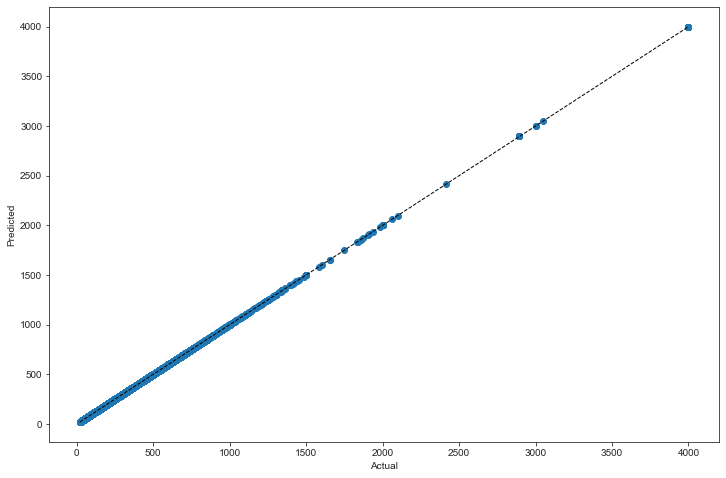

In [29]:
# model validation using sklearn cross_val_predict

lr = linear_model.LinearRegression()
y = knr_result.price

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, knr_result, y, cv=20)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')


###### MODEL TRAINING USING RANDOM FOREST REGRESSSION
 

In [30]:
# build and train the model

rfg = RandomForestRegressor(n_estimators=100,random_state=42,
    max_depth=10,
    min_samples_leaf=15,
    verbose=1)

rfg.fit(X_train, Y_train)
rfg_Y_pred  = rfg.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


###### RANDOM FOREST REGRESSION MODEL EVALUATION

In [31]:
# incorporate predicted price to test dataset

predictions = pd.Series(data=rfg_Y_pred, index=X_test.index, name='predicted_price')
rfg_result =X_test.join(predictions, how='left')
rfg_result = rfg_result.join(Y_test, how='left')

In [32]:
# compute Pearson and R2_score

rfg_cor =  rfg_result[['predicted_price', 'price']].corr()
print ('Pearson correlation: %s' % rfg_cor['predicted_price'][1])
print ('R-score: ', r2_score(Y_test, rfg_Y_pred))

# the Pearsons correlation of 0.886 shows a strong relationship between actual and predicted price 
# the R2-score shows 78.5% of the variation in price can be explained by the independent (x) variables

Pearson correlation: 0.886386773085179
R-score:  0.7855397723940385


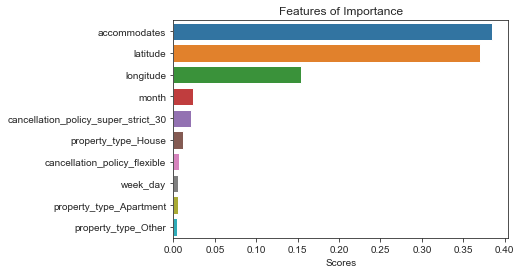

In [33]:
# display top 10 important features 
feature_importances = {}
features = X_train.columns
for feature_name, feature_importance in zip(features, rfg.feature_importances_):
    feature_importances[feature_name] = feature_importance
feature_importances_df = pd.DataFrame.from_dict(feature_importances,orient='index')
feature_importances_df = feature_importances_df.nlargest(10,0)

ax = sns.barplot(x=feature_importances_df[0], y=feature_importances_df.index, data=feature_importances_df)
ax.set(xlabel="Scores",title='Features of Importance')
sns.set({'figure.figsize':(12,5)})

SUMMARY:

1) September has the highest bookings, following is October. Feb has the lowest bookings. 
2) Apartment is the most demanded renting property, following by house and then condominium
3) Rental price is lowest in February and March, then gradually increases and reaches the peak in September and October.
4) Friday and Saturday prices, in general are more expensive than other days of the week
5) KNN Regression model is slightly more accurate in predicting prices, but Random Forest Regression provides important features had the most impact on determining the rental prices. 
